<a href="https://colab.research.google.com/github/aleena999/wbc_deepLearning/blob/main/Inception_WBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
!wget --no-check-certificate \
    "https://github.com/kittiekat/WBC_Classifier/archive/refs/heads/main.zip" \
    -O "/tmp/WBC_images.zip"


zip_ref = zipfile.ZipFile('/tmp/WBC_images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-05-25 07:16:29--  https://github.com/kittiekat/WBC_Classifier/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/kittiekat/WBC_Classifier/zip/refs/heads/main [following]
--2022-05-25 07:16:29--  https://codeload.github.com/kittiekat/WBC_Classifier/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/WBC_images.zip’

/tmp/WBC_images.zip     [        <=>         ]   1010M  18.0MB/s    in 64s     

2022-05-25 07:17:34 (15.7 MB/s) - ‘/tmp/WBC_images.zip’ saved [1059522558]



#Headers
NumPy for computation

plotly.express, matplotlib.pyplot, seaborn for visualization

tesnflow for training

sklearn.metrics for analyzing reports



In [ ]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
train_dir = '/tmp/WBC_Classifier-main/images/Rabin Data/Train'
test_dir = '/tmp/WBC_Classifier-main/images/Rabin Data/Test'

#Loading Image Data
Generators will load them few at a time, train on them and recycle memory.

**tf.keras.preprocessing.image.ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation

**preprocessing_function:** The function will run after the image is resized and augmented. The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.

**validation_split:** Fraction of images reserved for validation (strictly between 0 and 1)

In [ ]:
# Create generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

#Build Pretrained Model

87924736/87910968 [==============================] - 3s 0us/step


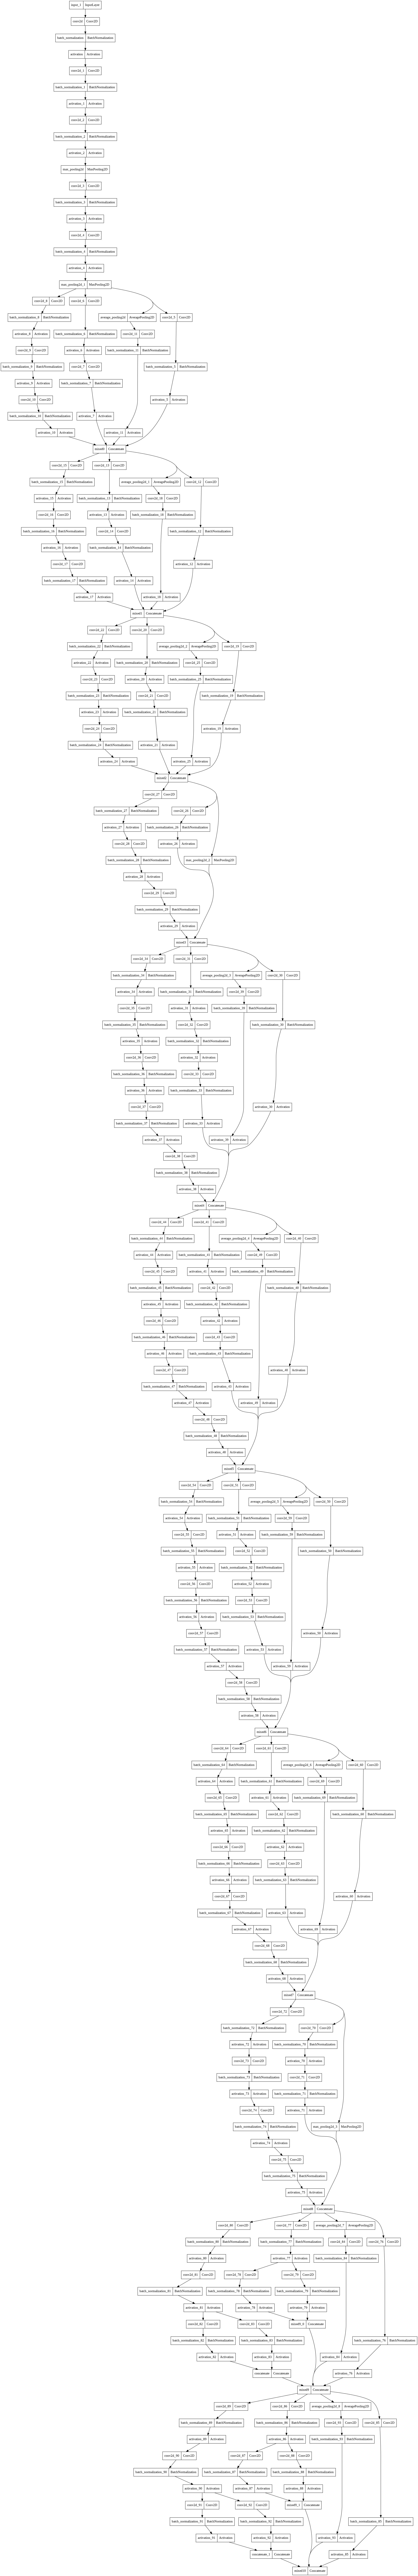

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten
inception=InceptionV3(include_top=False,weights='imagenet',
         input_shape=(224, 224, 3))
inception.trainable = False
plot_model(inception,to_file='model.png')

#Build Classification Model

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x=Flatten()(inception.output)
prediction_inception=tf.keras.layers.Dense(5,activation='sigmoid')(x)
##Create Inception Model
from tensorflow.keras.models import Model
inception_model=Model(inputs=inception.input,outputs=prediction_inception)
inception_model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


inception_history=inception_model.fit(train_images,
                          validation_data=val_images,
                          batch_size=32,
                          steps_per_epoch=100,
                          epochs=25,
                          callbacks=[
                                     tf.keras.callbacks.EarlyStopping(
                                         monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)
                                     ],
                          verbose=1)

#Training

In [ ]:
fig = px.line(
    inception_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

#Results

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

In [ ]:
predictions = np.argmax(inception_model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(inception_model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
# Utility
import itertools
import random
from collections import Counter
from glob import iglob
from imutils import paths
import cv2
import os



def load_image(filename):
    img = cv2.imread(os.path.join(test_dir, filename))
    img = cv2.resize(img, (224,224) )
    img = img /255
    
    return img

def predict(image):
    probabilities = inception_model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {CLASS_NAMES[class_idx]: probabilities[class_idx]}


for idx, filename in enumerate(random.sample(list(paths.list_images(test_dir)),10)):
    print("SOURCE: class: %s, file: %s" % (filename.split('/')[5], filename.split('/')[6]))
    print(idx)
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()